In [19]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

### Базовый класс

In [20]:
class BasicAgent:
    '''
    Базовый агент, от которого наследуются стратегии обучения
    '''

    # Наименование алгоритма
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        #и сама матрица
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps=eps
        # Награды по эпизодам
        self.episodes_reward = []

    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)

    def get_state(self, state):
        '''
        Возвращает правильное начальное состояние
        '''
        if type(state) is tuple:
            # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state

    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        return np.argmax(self.Q[state])

    def make_action(self, state):
        '''
        Выбор действия агентом
        '''
        if np.random.uniform(0,1) < self.eps:

            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)

    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize = (15,10))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()

    def learn():
        '''
        Реализация алгоритма обучения
        '''
        pass


### SARSA

In [21]:
class SARSA_Agent(BasicAgent):
    '''
    Реализация алгоритма SARSA
    '''
    # Наименование алгоритма
    ALGO_NAME = 'SARSA'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01

    def learn(self):
        '''
        Обучение на основе алгоритма SARSA
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Выбор действия
            action = self.make_action(state)

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Выполняем следующее действие
                next_action = self.make_action(next_state)

                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


### Q-обучение

In [22]:
class QLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Q-обучение'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01

    def learn(self):
        '''
        Обучение на основе алгоритма Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Правило обновления Q для SARSA (для сравнения)
                # self.Q[state][action] = self.Q[state][action] + self.lr * \
                #     (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Правило обновления для Q-обучения
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


### Двойное Q-обучение

In [23]:
class DoubleQLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Double Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Двойное Q-обучение'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Вторая матрица
        self.Q2 = np.zeros((self.nS, self.nA))
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        temp_q = self.Q[state] + self.Q2[state]
        return np.argmax(temp_q)

    def print_q(self):
        print(f"Вывод Q-матриц для алгоритма {self.ALGO_NAME}")
        print('Q1')
        print(self.Q)
        print('Q2')
        print(self.Q2)

    def learn(self):
        '''
        Обучение на основе алгоритма Double Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                if np.random.rand() < 0.5:
                    # Обновление первой таблицы
                    self.Q[state][action] = self.Q[state][action] + self.lr * \
                        (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])
                else:
                    # Обновление второй таблицы
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * \
                        (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)


In [29]:
def play_agent(agent):
    '''
    Проигрывание сессии для обученного агента
    '''
    env2 = gym.make('Taxi-v3', render_mode='human')
    state = env2.reset()[0]
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, _ = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True


In [25]:
def plot_rewards(x, y):
    # Построение графика наград по эпизодам
    fig, ax = plt.subplots(figsize = (15,10))
    plt.plot(x, y, '-', linewidth=1, color='green')
    plt.title('Награды')
    plt.xlabel('Параметр')
    plt.ylabel('Награда')
    plt.show()

In [30]:
def bruteforce_sarsa():
    env = gym.make('Taxi-v3')
    rewards_eps = []
    rewards_lr = []
    rewards_gamma = []
    x = np.arange(0.1, 1, 0.1)
    for i in x:
        agent = SARSA_Agent(env,eps=i)
        agent.learn()
        agent.print_q()
        rewards_eps.append(np.asarray(agent.episodes_reward).sum())
    plot_rewards(x, rewards_eps)
    best_eps = x[rewards_eps.index(max(rewards_eps))]
    print(f"Best eps: {best_eps}")
    x = np.arange(0, 1, 0.03)
    for i in x:
        agent = SARSA_Agent(env, eps = best_eps, lr = i)
        agent.learn()
        agent.print_q()
        rewards_lr.append(np.asarray(agent.episodes_reward).sum())
    best_lr = x[rewards_lr.index(max(rewards_lr))]
    print(f"Best lr: {best_lr}")
    plot_rewards(x, rewards_lr)
    x = np.arange(0, 1, 0.03)
    for i in x:
        agent = SARSA_Agent(env, eps = best_eps, lr = best_lr, gamma = i)
        agent.learn()
        agent.print_q()
        rewards_gamma.append(np.asarray(agent.episodes_reward).sum())
    best_gamma = x[rewards_gamma.index(max(rewards_gamma))]
    print(f"Best gamma: {best_gamma}")
    plot_rewards(x, rewards_gamma)
    print(rewards_eps)
    print(rewards_lr)
    print(rewards_gamma)
    print(f"Best params: eps={best_eps}, lr={best_lr}, gamma={best_gamma}")

def run_sarsa():
    env = gym.make('Taxi-v3')
    agent = SARSA_Agent(env, eps=0.1, lr=0.33, gamma=0.99)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def run_q_learning():
    env = gym.make('Taxi-v3')
    agent = QLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

def run_double_q_learning():
    env = gym.make('Taxi-v3')
    agent = DoubleQLearning_Agent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)


### Bruteforce SARSA

100%|██████████| 20000/20000 [00:02<00:00, 7185.51it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.23274181 -1.00382735 -2.57537425  0.99129089  7.61098902 -4.41183473]
 [ 1.04820728  0.75951016 -1.47976794  1.01463375 12.48488619 -2.647267  ]
 ...
 [-1.13374751  7.30463262 -1.15041055 -1.13004597 -1.9        -2.75609259]
 [-3.2743139  -3.25956333 -3.34521036  2.42474347 -5.37469262 -5.70662405]
 [-0.19       -0.1998     -0.19       14.34628921 -1.9        -1.9098    ]]


100%|██████████| 20000/20000 [00:02<00:00, 7070.83it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -5.23711196  -0.55593023  -4.03136788  -3.62803799   8.03476031
  -10.17951991]
 [  1.76797738   2.88074108   1.06871364   2.40565628  12.87477488
   -2.53738071]
 ...
 [  4.91838358  13.73471961   4.46141594   3.12250741  -3.56077177
   -1.02670006]
 [ -3.8837365   -2.88695918  -3.87228241  -3.83251645  -7.49733552
   -6.83152654]
 [ -0.614134    -0.297604    -0.297558    16.58243663  -1.01862
   -1.74574732]]


100%|██████████| 20000/20000 [00:03<00:00, 6472.62it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.36513042  -1.82872199  -4.43285719  -0.85409467   7.97876097
  -12.98035115]
 [  1.92114492   3.60011992  -1.83728578   3.77297702  13.15773705
   -6.13728125]
 ...
 [ -2.2363561    1.26616845  -2.13453864  -2.31784318  -4.39078238
   -4.38532396]
 [ -5.41996113  -5.69163539  -5.29245975  -0.70412275  -8.20793619
   -8.78640837]
 [  0.3279506   13.74947689   0.23307575   1.76999905  -1.47416408
   -1.06975647]]


100%|██████████| 20000/20000 [00:03<00:00, 5878.34it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -8.32044253  -6.04162319  -8.98410364  -6.02408628   8.11250435
  -11.86602266]
 [ -0.94520798   3.68330324   1.61055798   1.42385681  13.18933856
   -6.02859967]
 ...
 [ -2.52352302   3.41628669  -2.20621461  -2.69883854  -7.38566506
   -4.60023694]
 [ -7.89398148  -3.2212472   -7.80653201  -8.25218737 -10.75864579
   -9.77531085]
 [ 10.87081404   5.645553     8.06627258  18.37034376   2.7401223
    3.11125792]]


100%|██████████| 20000/20000 [00:03<00:00, 5200.38it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-11.9093799  -10.48524349  -5.68794114  -2.85114773   6.27686962
  -14.68033704]
 [  0.75648686   2.14356165   3.30783843   4.8751255   13.26105369
   -5.07367049]
 ...
 [ -1.15730471   7.25784239  -0.39424346  -4.65648486  -7.40249229
   -9.29590289]
 [-12.83907922  -6.85830286 -12.77819291 -11.63400007 -17.92896643
  -19.5177472 ]
 [  4.91121648   4.538315     7.32353227  18.33129225  -0.81618047
    2.64929005]]


100%|██████████| 20000/20000 [00:04<00:00, 4625.73it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-11.78032467 -10.45264404 -10.92158685  -7.63763007   7.72231719
  -18.18067543]
 [ -0.79180072   5.63894282  -0.8549878    4.45647623  12.88049989
   -5.07344561]
 ...
 [ -2.3842387    9.18796808  -5.1645348   -6.22421697 -10.98011336
  -14.88223907]
 [-18.52149985 -18.17321039 -18.87043461  -7.65191113 -26.58942446
  -26.26602741]
 [ 11.43138282   2.60620001  11.39042225  18.46638126   3.88736517
   -0.90344088]]


100%|██████████| 20000/20000 [00:05<00:00, 3799.60it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.53294675e+01 -1.32163391e+01 -1.94819578e+01 -8.58707641e+00
   8.11165962e+00 -2.34699972e+01]
 [ 8.72889332e-01  2.22282065e+00 -3.33543469e-02  1.44151728e+00
   1.32283682e+01 -5.97867652e+00]
 ...
 [-1.41300454e+01  4.23806016e+00 -1.47465869e+01 -1.49135912e+01
  -2.46655130e+01 -1.86320529e+01]
 [-2.86299597e+01 -2.55341628e+01 -2.78527168e+01 -6.11820221e+00
  -3.62463387e+01 -3.33832468e+01]
 [ 1.26351099e+01  8.58111923e+00  1.26046483e+01  1.84284086e+01
   5.39165426e+00  3.59799922e+00]]


100%|██████████| 20000/20000 [00:06<00:00, 3206.79it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-21.38430273 -15.25606812 -20.94742202  -9.64087815   8.34974797
  -24.8809802 ]
 [ -9.43878044   3.19839463  -3.30949796   0.46908948  13.20193894
   -9.48777985]
 ...
 [-15.40196981   5.72203283 -16.62412654 -14.55569539 -24.09764606
  -25.44831251]
 [-36.52350291 -38.29887243 -38.47818095  -6.05948052 -47.79908609
  -49.68626867]
 [ 14.51636338  10.77053494  15.37286064  18.33486515   5.35426693
    6.21178078]]


100%|██████████| 20000/20000 [00:07<00:00, 2549.23it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-17.22231893 -18.66467878 -14.17806361 -13.96244622   7.56777405
  -30.97481204]
 [ -3.07751578  -2.82944226  -8.20193588   3.45622923  13.10161921
   -9.54801087]
 ...
 [-31.86704438   0.44193911 -23.96887381 -27.23871959 -30.26626974
  -34.42468335]
 [-48.17347819 -54.39508183 -58.10715766  -7.51118449 -58.71538432
  -61.28609793]
 [ 14.27288009  10.18937659  16.10716736  18.48109366   5.63642526
    6.49304135]]


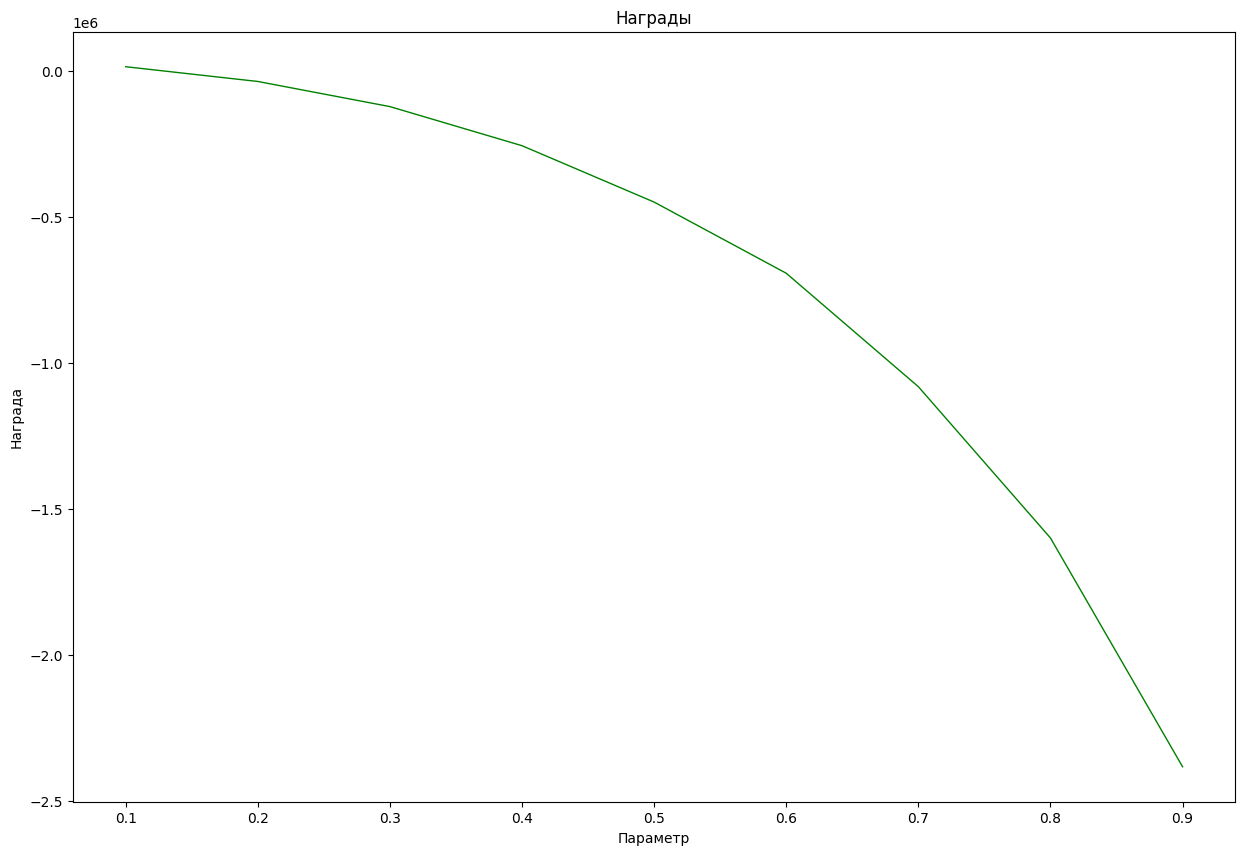

Best eps: 0.1


100%|██████████| 20000/20000 [00:28<00:00, 704.01it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


100%|██████████| 20000/20000 [00:03<00:00, 5344.44it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.45214463 -3.29835793 -3.19058334 -2.45861277  7.394871   -4.04521111]
 [-1.63995066 -1.10078683 -1.12673279  0.56257839 12.62182752 -2.43337278]
 ...
 [-0.87959326 -0.69100941 -0.88234457 -0.8836742  -1.76030714 -0.89081841]
 [-2.41657862 -2.39334224 -2.4101106  -2.43249952 -2.63975848 -2.64125917]
 [-0.0591     -0.059982   -0.0591      4.06161626 -0.3        -0.591882  ]]


100%|██████████| 20000/20000 [00:02<00:00, 6702.68it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.51131653 -1.62194744 -1.63653211 -2.57917655  7.24690456 -4.16574126]
 [ 1.3015353   0.46372928  0.85476615 -1.22929521 12.88055778 -3.5426139 ]
 ...
 [-1.40950226 -1.18019813 -1.41562112 -1.40315232 -2.80421472 -2.32888545]
 [-2.63775741 -2.50310388 -2.72069429 -2.64252597 -2.93553174 -3.92021974]
 [-0.1164     -0.06       -0.1164     11.01451095  0.          0.        ]]


100%|██████████| 20000/20000 [00:02<00:00, 7194.17it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.50096184 -1.81841628 -3.16327459 -0.82247225  7.30448587 -6.13642391]
 [-0.05660427  2.39599588 -0.84322114 -0.7692736  13.2090311  -2.91882787]
 ...
 [-1.09631013 -0.30711879 -1.11999904 -1.05590575 -2.54415396 -1.726938  ]
 [-2.91899754 -2.92905912 -2.90273897 -2.60037371 -4.34007501 -4.78865711]
 [-0.1719     -0.179838   -0.1719     13.60191558 -1.719      -1.726938  ]]


100%|██████████| 20000/20000 [00:02<00:00, 7685.02it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.70661295 -2.49396948 -3.13764256  0.02107194  7.53081358 -4.61991651]
 [ 1.16812049  4.29499764 -0.64694329  0.55425295 12.93266619 -0.76855008]
 ...
 [-1.24012128  0.68528388 -1.2374078  -1.32537318 -2.256      -3.25063997]
 [-2.97597627 -2.87437735 -2.90033096 -1.36763597 -3.31959763 -4.51592609]
 [-0.34505856 -0.34505856 -0.35747712 12.56612181 -2.256      -2.270112  ]]


100%|██████████| 20000/20000 [00:02<00:00, 7842.57it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.31593339 -0.50851092 -4.54070143 -2.86835298  7.95731549 -5.02051557]
 [ 0.89982404  0.76890074  3.41452938  5.30328817 13.22712108 -0.0305506 ]
 ...
 [-1.44829111 -0.22931405 -1.62641694 -1.43567412 -3.98087416 -3.92152635]
 [-3.94988427 -1.61316215 -4.18082346 -3.97358247 -6.63342772 -6.73551235]
 [-0.2775     -0.29955    -0.4046175  16.33920649 -2.775      -2.79705   ]]


100%|██████████| 20000/20000 [00:02<00:00, 8048.00it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.46405136  1.04398497 -0.53147174 -2.75678308  8.0963435  -5.10520072]
 [ 2.14411718  6.25762232  1.82481779  1.4980794  13.18192782 -4.4621349 ]
 ...
 [-1.62924281  1.89758905 -1.6444347  -1.72339012 -4.54410864 -5.09024304]
 [-4.09365131 -3.84002809 -4.02855689  0.2287186  -6.08958537 -6.57915253]
 [-0.3276     -0.359352    0.90128411 18.08450607 -3.276      -3.307752  ]]


100%|██████████| 20000/20000 [00:02<00:00, 7934.44it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-6.17734849  2.58826877  3.2290773   3.31842783  6.79549377 -8.87475449]
 [-2.33688898  4.12186933  3.31212399  0.72591593 13.07073608  0.48084465]
 ...
 [-1.65784731  6.22260541 -1.50200364 -1.38259066 -5.20983053 -6.34904811]
 [-4.31614733 -1.39071347 -4.26002443 -4.31869605 -7.16481974 -7.53875136]
 [-0.3759     -0.419118   -0.3759     16.1083973  -4.96908493 -3.802218  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8308.90it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.58191027  0.50511819  1.16820882  1.50913885  8.06902198 -4.80517046]
 [-1.01959118  5.42695957 -2.41440409  7.79867076 13.24353856  0.64464962]
 ...
 [-1.45439236 11.29947283 -1.85271649 -1.57868431 -4.224      -5.87420431]
 [-4.15835872 -2.79101414 -4.38399283 -4.11298483 -4.224      -6.5711501 ]
 [-0.84123156 -0.68373924 -0.84123156 14.93438488 -2.4        -4.280448  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8234.69it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.96317878 -0.3653812   3.34963285 -5.60846886  7.88980355 -5.54100539]
 [ 4.26141068  8.12472136  6.85846604  0.49086121 13.23362548  1.72897209]
 ...
 [-1.85556541 12.71753483 -1.88372072 -1.73278359 -2.771442   -4.742442  ]
 [-4.65538442 -4.70703991 -4.72423687  1.25932741 -6.73092354 -8.27554358]
 [-0.4671     -0.4671     -0.4671     18.59977493 -4.671      -4.742442  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8223.71it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.08781769  1.45277544 -1.321829    0.76790638  6.80041671 -4.58750706]
 [ 4.22532261  1.0908686   3.84935917  8.47670361 13.27443847 -2.95954384]
 ...
 [ 4.27406902 14.56526245  8.84838697  2.5930104   2.27178337  1.05110993]
 [-4.70355686  0.55864405 -4.869633   -4.42588095 -7.42621061 -8.10113754]
 [-0.51       -0.3        -0.51       18.43397099  0.          0.        ]]


100%|██████████| 20000/20000 [00:02<00:00, 8459.83it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.47104271  5.09483892 -2.39625478  2.45022125  8.29327225 -7.86202412]
 [ 6.11826855  7.6282694   7.74655258  1.83100345 13.27444687 -1.8526795 ]
 ...
 [-2.41778478  0.42668449 -2.32646576 -2.72890259 -7.65439439 -3.406722  ]
 [-3.29815546  4.17998684 -3.28533692 -3.21380267 -7.20510963 -5.617722  ]
 [-0.699237   14.78834181 -0.72932574 -0.5511     -5.511      -5.617722  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8217.99it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.98773027  2.94222073 -0.20301342  3.26355249  7.93271001 -6.67619847]
 [ 0.47386805  5.15843261  4.92968078  0.8872445  10.63877857 -2.86740729]
 ...
 [-2.35011188  1.64686462 -2.19569751 -2.22583346 -5.904      -6.031008  ]
 [-3.8586998  -3.4554739  -3.50014241  2.72606808 -7.72016072 -7.9338136 ]
 [-0.5904     -0.717408   -0.94614912 17.73845866 -3.6        -6.031008  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8422.04it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.19177907  0.41898756 -4.44532416  2.19164933  8.04316964 -3.37023696]
 [ 5.00061395  7.01389397  3.01297326  3.62944975 12.53772553  1.15427364]
 ...
 [-2.51077867  2.72059911 -2.61550514 -3.0277338  -6.279      -6.428058  ]
 [-5.48246124 -5.81169536 -5.36166308  4.46106929 -8.02714335 -6.428058  ]
 [-0.6279     -0.539058   -0.6279     18.59999988 -6.279      -6.428058  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8047.45it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.07067451  2.57481573 -6.58557012  3.53418889  5.39397022 -2.54899954]
 [ 3.09728086  5.14042314  3.83297037 10.07545111 13.0281335  -1.61057758]
 ...
 [ 2.0468496  14.56577006  8.29475427  0.97531843  3.87749671 -2.15423506]
 [-4.69038512  3.4367871  -4.87105975 -4.41924601 -6.636      -6.808872  ]
 [-0.6636     -0.836472   -0.6636     18.53190639 -6.89893546 -6.808872  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8217.77it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.44990416  1.23084518  0.90772621  1.15096357  6.63938553 -4.96504287]
 [ 2.47990075  6.77007659  6.2603655   4.91741721 13.2065515  -1.14262217]
 ...
 [-4.28053537 -4.37538988 -4.76879274 10.83665524 -6.975      -7.17345   ]
 [-2.48244006  3.60278747 -3.87782701 -4.56892213 -8.6438475  -9.17499802]
 [-1.38526987 -1.33690412 -1.41177287 18.58516786 -6.975      -4.69845   ]]


100%|██████████| 20000/20000 [00:02<00:00, 7682.63it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.19882664  -0.12217467   0.03963286  -0.08347884   8.36162275
   -9.42049017]
 [  0.2386811    1.3476913    2.68238228   3.61866222  13.13294322
  -12.59759757]
 ...
 [ -2.50436463  10.02948221  -2.67406827  -2.55128602  -7.296
   -7.521792  ]
 [  0.32896791   8.99264103   0.49301536   0.62685795  -2.54947871
   -2.35208225]
 [ -0.7296      -0.955392    -0.7296      18.59512751  -7.296
   -7.521792  ]]


100%|██████████| 20000/20000 [00:02<00:00, 7769.20it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 3.61596309  4.4134132   2.61332826  1.47923141  8.35861954 -2.90122808]
 [ 3.45946499  5.62665559  7.57764363  6.35655111 13.27445366 -2.50571079]
 ...
 [-6.42101792 -5.81595268 -6.14813385  8.5915254  -9.54734537 -7.853898  ]
 [-6.19472994 -5.91604322 -6.33045465  2.08348695 -7.853898   -9.17396786]
 [-0.7599      2.92996474  2.95906495 18.6        -0.1689893   0.34786998]]


100%|██████████| 20000/20000 [00:02<00:00, 7771.61it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.19249887  -1.40474225  -0.39562619  -7.29135689   8.35827481
   -2.23477574]
 [ -3.92350251   5.32775874   4.01384362   0.53567606  12.54544487
    0.76661217]
 ...
 [ -3.21617844   0.80050211  -3.41028273   4.0918544   -2.75774305
  -10.35156486]
 [ -6.87544855  -6.84717547  -7.17177235  -7.09640227 -12.3569755
  -11.17878624]
 [  2.37400825   6.89883093  -0.7884      18.6          0.11217882
   -8.169768  ]]


100%|██████████| 20000/20000 [00:02<00:00, 7847.21it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.43332787  -3.73483195 -11.26886751   2.5178287    8.3623049
   -5.98626794]
 [  5.45545039   1.4035354    0.77376672   3.41161211  13.27445578
  -12.38519217]
 ...
 [ -5.71474598   8.86082137  -6.55781016  -7.43158488 -10.48707951
   -8.469402  ]
 [ -5.75158015  -5.65892051  -5.84205543   6.82846039  -8.151
   -8.469402  ]
 [ -0.8151      -5.3682486   -0.8151      18.59974032  -8.469402
   -5.7       ]]


100%|██████████| 20000/20000 [00:02<00:00, 7644.16it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.90250464  -5.74982633  -7.05075807  -4.88130085   7.53106803
  -11.35731393]
 [ -3.40766554   0.59627719   1.19731839   1.004022    13.15691475
   -2.19290721]
 ...
 [  4.67537582  11.11961088  -2.97478474  -3.13831752  -6.
   -8.89392   ]
 [  2.85209547   8.31215059   0.68540549  -4.12384908  -5.13084548
   -3.88372564]
 [ -0.84        -1.57104     -0.84        18.59496683  -8.4
  -11.124     ]]


100%|██████████| 20000/20000 [00:02<00:00, 7653.09it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.94746707   5.01754981  -4.50276268   2.24995122   8.11340118
   -6.14989605]
 [ -4.37184151   1.56804851  -3.99602674   5.89541367  13.13278813
  -11.86903412]
 ...
 [ -6.38218719   9.5533784   -5.57995396  -2.11650365  -8.631
  -11.62396254]
 [ -8.47614438  -8.6441119   -8.90423591   7.72543102 -10.830356
  -11.21280221]
 [ -0.8631      -1.252062    -0.8631      18.6          1.99017
   -9.019962  ]]


100%|██████████| 20000/20000 [00:02<00:00, 7244.26it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.77618243  -3.78411648   1.32442669  -6.30795945   7.53999593
  -10.85807326]
 [ -6.05948382  -4.07459173  -4.0568491   -3.63944905  13.27404967
   -4.18398821]
 ...
 [ -4.89328682  12.00896634  -4.54988872  -4.94087139  -8.38605543
   -1.63732349]
 [ -5.84173785   7.19186241  -9.82413587  -3.63866604  -5.6101222
   -7.55984738]
 [ 16.8236838   10.34570322   0.46506478  18.6          3.76444231
    7.34743861]]


100%|██████████| 20000/20000 [00:02<00:00, 7200.47it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.50783613e+00 -4.12096684e+00 -3.31853094e+00 -6.13271657e+00
   8.32599589e+00 -1.45585423e+01]
 [-5.45719937e-03 -6.51585189e+00 -1.07872214e+00  5.88288090e+00
   1.07472156e+01 -1.05607428e+00]
 ...
 [-1.38837142e+00  4.57142410e+00  4.96610290e+00 -2.79421823e+00
  -1.50300459e+01 -3.20199677e+00]
 [-1.49398455e+01 -1.13624635e+01 -1.21667962e+01 -2.99878350e-01
  -1.89963833e+01 -1.82360271e+01]
 [ 9.15634756e+00  9.15964119e+00  1.51833159e+01  1.86000000e+01
   8.06402158e+00  6.52378344e+00]]


100%|██████████| 20000/20000 [00:02<00:00, 6996.09it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -7.60927566   0.47646429 -10.15185881   1.11116575   6.6436652
  -18.59168458]
 [ -1.05111864  -5.88262921  -3.61219851  -7.9130895   13.27445566
   -1.18439978]
 ...
 [ -8.46190659  -8.78134208  -8.65133221  -5.77805513  -9.724032
  -16.38033237]
 [-13.77597161 -16.61858812 -14.00117447   3.05510303 -18.30903018
  -22.18597428]
 [ -0.9216      -1.57188096  -0.9216      18.6          3.34368
    3.20102139]]


100%|██████████| 20000/20000 [00:02<00:00, 6883.72it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -7.48578281 -12.57403577  -8.11722676 -12.44591156   8.36234254
  -14.78831791]
 [ -1.83189009  -5.47876913  -5.40365309  -8.14459652  13.27445578
   -8.23727853]
 ...
 [ -6.93474556  -6.38422199  -7.07148861   7.62284795  -9.375
   -9.92625   ]
 [-17.47299374 -17.4767936  -17.25127012 -11.27745542 -23.76949026
  -21.24440753]
 [  0.07965348  14.41710954  -1.1221875   -2.99063009  -7.34358987
   -4.33618632]]


100%|██████████| 20000/20000 [00:03<00:00, 6593.54it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-13.67861473 -13.62029866 -11.31250978 -13.52948905   8.32300162
  -14.52782645]
 [ -5.78565936  -4.17164584  -8.11774565  -8.265402    13.27408237
   -1.08976937]
 ...
 [ -8.92450975  11.47257117  -9.50611978  -6.2497964  -12.46873259
   -7.27679201]
 [ -9.07473709   9.53451797  -0.49324824  -9.70031686 -20.99830101
   -3.07143667]
 [ 12.24463175   9.26891912  12.95171087  18.6         -9.516
   -8.52740304]]


100%|██████████| 20000/20000 [00:03<00:00, 6127.74it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-17.79311703 -10.95617105 -12.45593359 -13.00111695   8.3623423
  -25.07801099]
 [ -6.60474399  -1.4264901   -1.52804859  -1.37459629  13.27445202
  -13.16048226]
 ...
 [  7.49825833  12.00896666 -13.20963039  -4.27022061  -1.90753104
  -12.62964524]
 [-19.43191458 -14.61851171 -15.06344057 -17.98704395 -25.19660987
  -24.82277845]
 [ 15.77039123   8.38352316   9.24615523  18.6          8.19614954
    8.22502209]]


100%|██████████| 20000/20000 [00:03<00:00, 6134.86it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-14.29202818 -19.00583314 -18.6508921  -19.18060777   8.26116846
  -21.90728286]
 [-11.37940038 -15.74588577 -11.6087324  -11.28758067  13.27445578
  -17.93160358]
 ...
 [-12.09016892 -14.40901414 -11.9296203    8.26930209 -19.32770494
  -14.11476832]
 [-17.97917192 -17.85895922 -18.12880695 -17.53325103 -21.00488367
  -23.23221349]
 [ 14.315616     0.03671829  -0.9744      18.6         -9.63719383
    7.75021471]]


100%|██████████| 20000/20000 [00:03<00:00, 5676.42it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-19.8387687  -19.74997528 -19.65066592 -19.59122403   8.36234335
   -7.43921791]
 [-18.11071362 -17.90893476 -18.07256708 -17.92275351  13.27445578
  -22.00835322]
 ...
 [  7.16874535  12.00889516 -16.88201063 -18.12609355 -18.06724142
  -20.89062414]
 [-26.14898512 -26.05108613 -26.38908888 -21.00224527 -26.59445068
  -32.98152483]
 [ -0.51791004   5.5174074   16.11319952  18.6         -9.831
    5.90498756]]


100%|██████████| 20000/20000 [00:03<00:00, 5231.51it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-30.01083248 -29.97948711 -29.7744517  -29.93131733   5.81901044
  -33.31902313]
 [-18.14796059   6.61951857 -19.24994607  -3.62861625  10.76878731
   -5.82792624]
 ...
 [ -2.36640884  12.89616823 -16.65287768 -14.65598047 -14.29229989
  -20.14878313]
 [-28.38878014 -26.41028877 -28.27764977 -28.22146975 -26.46446003
  -34.83809519]
 [ -1.960398     1.3242528   -0.99        -0.99        -9.9
  -10.86318   ]]


100%|██████████| 20000/20000 [00:04<00:00, 4868.60it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-31.60448494 -30.40582277 -30.44651807 -30.68534064   8.36104056
  -37.57051726]
 [-15.8112442  -14.89826286 -15.66159505 -15.3379175   13.27445578
  -18.89794458]
 ...
 [-20.42255447 -22.57324034 -21.65098145  -7.67785649 -24.57258513
  -17.87450254]
 [-29.93317208 -16.7273982  -29.88275946 -28.2881823  -28.17397689
  -32.47061082]
 [-15.50315965   0.41060257 -14.26825301  18.6          7.51940999
    7.50355156]]


100%|██████████| 20000/20000 [00:05<00:00, 3843.86it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-36.70970948 -24.72263666 -40.97233941 -39.04033584   5.87543984
  -37.20827746]
 [-26.83600458 -27.44206685 -26.83914059 -40.85529103  13.27442324
  -27.86208671]
 ...
 [-27.534389    14.56577084  11.63481072 -27.36089984 -34.94873759
  -27.82894882]
 [-41.44592183 -43.70574205 -41.38776528 -41.37500517 -50.17136561
  -49.1716869 ]
 [  8.72234328  14.18110425  16.83032265  18.6          3.77204938
    8.226859  ]]


100%|██████████| 20000/20000 [00:06<00:00, 3178.48it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-57.37881126 -58.66288719 -49.99222899 -55.24933766   8.36234333
  -58.86935285]
 [-31.94004741 -31.94995299 -32.26644051 -31.98699498  10.76873362
  -38.92321823]
 ...
 [-29.10967978  14.5657712  -28.99149929 -29.54585224   3.93799042
  -31.93272344]
 [-45.87411307 -45.88205041 -45.84133846 -45.86865113 -48.14686501
  -54.84932307]
 [-14.27081904  10.7829053   11.65306728  17.24172    -10.960488
  -13.79078335]]
Best lr: 0.32999999999999996


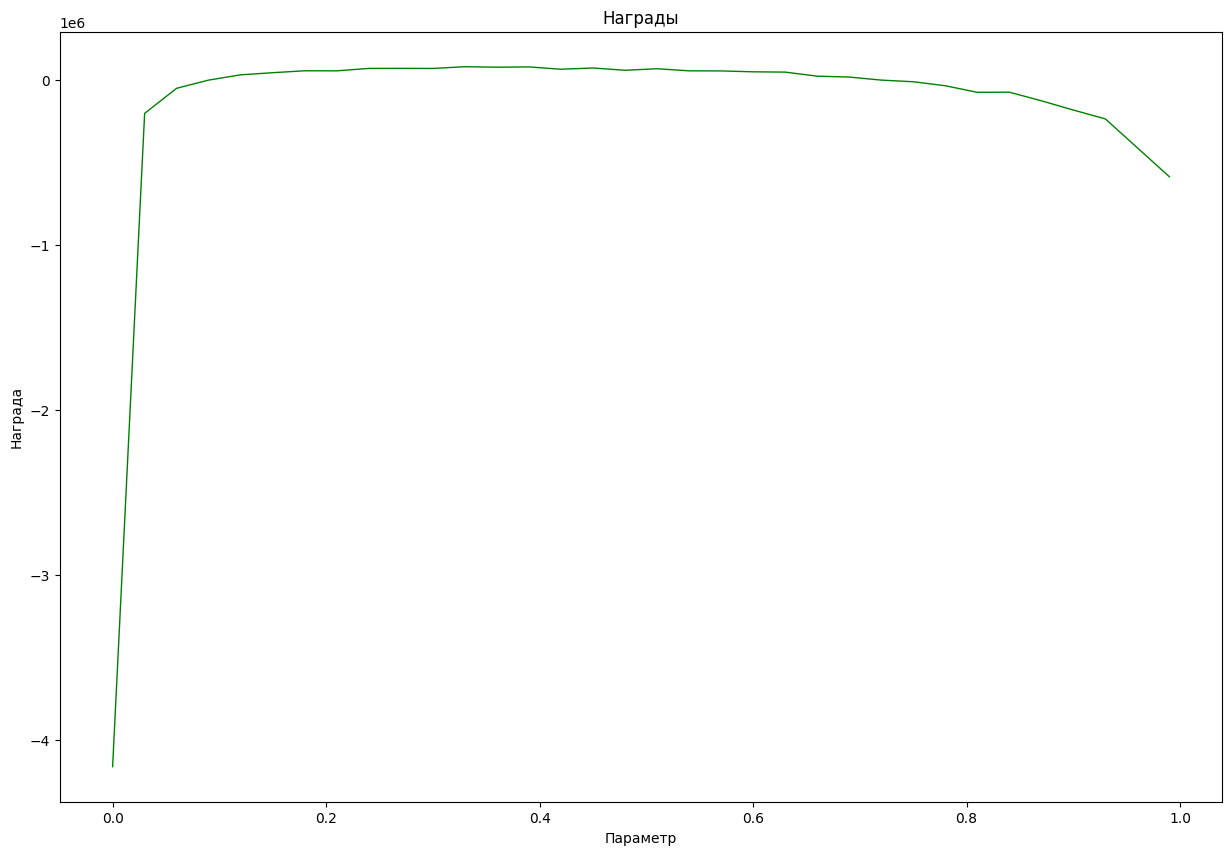

100%|██████████| 20000/20000 [00:28<00:00, 702.16it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.         -1.         -1.         -1.         -1.         -9.59393232]
 [-1.         -1.         -1.         -1.         -1.         -9.09541618]
 ...
 [-1.         -1.         -1.         -1.         -7.9848879  -6.99237   ]
 [-1.         -1.         -1.         -1.         -9.09541618 -7.9848879 ]
 [-0.98778699 -0.98778699 -0.99181728 -0.98778699 -5.511      -6.99237   ]]


100%|██████████| 20000/20000 [00:23<00:00, 848.78it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.05772393  -1.04888656  -1.03092788  -1.07092101  -1.12003653
  -10.03103156]
 [ -1.12003398  -1.09062663  -1.03092784  -1.07093578  -1.07091024
  -10.03112369]
 ...
 [ -1.11733132  -1.08161413  -1.11953858  -1.03135888 -10.00634004
   -9.94921358]
 [ -1.11987047  -1.03092785  -1.1198946   -1.12018607  -9.99428226
  -10.02436583]
 [ -0.80476025  -0.71144472  -0.80763247  -0.40000056  -5.511
   -5.51645589]]


100%|██████████| 20000/20000 [00:23<00:00, 866.00it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.14382629  -1.11745267  -1.24209311  -1.14385283  -1.24203016
  -10.06688127]
 [ -1.24205674  -1.24206185  -1.24206556  -1.2420761   -1.06381378
  -10.06723129]
 ...
 [ -1.18310228  -1.06398904  -1.24190767  -1.24208258 -10.04053749
  -10.06112226]
 [ -1.24062795  -1.06417437  -1.24100346  -1.14382069 -10.04175033
  -10.04199081]
 [ -0.87323668  -0.71972759  -0.92324068   0.2         -5.511
   -5.517534  ]]


100%|██████████| 20000/20000 [00:24<00:00, 829.94it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.17951554  -1.13502574  -1.17940575  -1.27815006  -1.0989016
  -10.1040635 ]
 [ -1.09911943  -1.36611642  -1.1900121   -1.21911705  -1.2781854
  -10.09870111]
 ...
 [ -1.35794448  -1.25077267  -1.25052392  -1.10246958 -10.04393563
   -9.17768587]
 [ -1.36660385  -1.36630187  -1.27823329  -1.0989011  -10.11331361
  -10.08999294]
 [ -0.699237    -0.33        -0.5511       0.79997     -3.31636767
   -5.51497921]]


100%|██████████| 20000/20000 [00:21<00:00, 911.94it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.29487241  -1.29781849  -1.37462918  -1.49331488  -1.1373315
  -10.14249888]
 [ -1.296066    -1.37533257  -1.20903726  -1.37527787  -1.13635888
  -10.13789292]
 ...
 [ -1.27164622  -1.16652927  -1.3216718   -1.13814098  -9.51662666
   -9.50992792]
 [ -1.37459106  -1.14276793  -1.49189832  -1.37600958 -10.14134242
  -10.12927222]
 [ -0.5511      -0.72841933  -0.57292356   1.2671492   -5.511
   -5.51371814]]


100%|██████████| 20000/20000 [00:19<00:00, 1044.43it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.17648339  -1.28462204  -1.37651611  -1.62204565  -1.62708849
  -10.18161146]
 [ -1.62129063  -1.37664402  -1.17647743  -1.62621123  -1.37718873
  -10.19044967]
 ...
 [ -1.57600702  -1.38512636  -1.55312968  -1.18041811  -9.55656367
   -9.76288311]
 [ -1.31074627  -1.18094496  -1.47449297  -1.47593105 -10.16902154
  -10.18969367]
 [ -0.84485405  -0.75159873  -0.92397107   1.88942322  -3.32727945
   -5.527335  ]]


100%|██████████| 20000/20000 [00:22<00:00, 901.41it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.57999906  -1.57890072  -1.5788958   -1.38046112  -1.21951018
  -10.22266735]
 [ -1.22075973  -1.57445236  -1.75375605  -1.74654089  -1.74448875
  -10.19739777]
 ...
 [ -1.54809631  -1.56969334  -1.71735266  -1.22542093  -9.94268204
   -9.87042045]
 [ -1.56894292  -1.21950374  -1.74740537  -1.75504863 -10.19773917
  -10.15804344]
 [ -0.5511      -0.570702    -0.5511       1.12432814  -5.511
   -5.530602  ]]


100%|██████████| 20000/20000 [00:22<00:00, 870.12it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.29293061  -1.89022674  -1.45837425  -1.46028467  -1.39310424
  -10.2753515 ]
 [ -1.68321303  -1.68516945  -1.6855108   -1.45583796  -1.27941333
  -10.27475856]
 ...
 [ -1.82367224  -1.2244648   -1.3995494   -1.89417881  -9.6223192
   -9.83841853]
 [ -1.68865241  -1.27364159  -1.89109523  -2.3124532  -10.27412173
  -10.29680447]
 [ -0.47747704  -0.7573579   -0.39531116   3.2         -6.77085286
   -8.18686578]]


100%|██████████| 20000/20000 [00:22<00:00, 902.77it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.31722662  -2.03203092  -1.64441326  -2.02925004  -2.02924295
  -10.38324867]
 [ -1.63635288  -1.46217005  -1.63714582  -1.63476588  -1.30712405
  -10.32549209]
 ...
 [ -1.95174706  -1.90874738  -1.91451278  -1.38520987 -10.1347955
   -9.68175639]
 [ -1.7899407   -1.7635123   -1.45673873  -1.32728259 -10.30857205
  -10.29550244]
 [ -0.5511      -0.577236    -0.5511       3.61555562  -5.511
   -5.537136  ]]


100%|██████████| 20000/20000 [00:21<00:00, 944.05it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.72762442  -2.17766309  -1.89257259  -2.1730539   -1.36986704
  -10.39634822]
 [ -1.89467101  -2.11493899  -1.77733893  -2.08613202  -1.33919985
  -10.18942577]
 ...
 [ -2.0576223   -1.2562948   -2.00090209  -2.11559105  -9.98470535
   -8.28731334]
 [ -1.9885799   -1.55299621  -2.11910316  -2.15462961 -10.25964545
   -9.47761428]
 [ -0.307197    -0.580503    -0.5511       4.4         -5.511
   -5.540403  ]]


100%|██████████| 20000/20000 [00:20<00:00, 985.17it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.83060965  -2.03311358  -1.56203106  -2.32825309  -1.42870701
  -10.46336556]
 [ -1.61629314  -1.60276245  -2.03008873  -2.02258676  -1.38406551
  -10.45701988]
 ...
 [ -1.56308014  -1.41297749  -1.70681703  -1.88610107  -8.98317738
   -8.23319233]
 [ -2.32506683  -2.32373668  -2.32032411  -1.4286144  -10.44388306
  -10.46950121]
 [ -0.88960215  -0.731907    -0.89553822   4.55199407  -5.511
   -5.54367   ]]


100%|██████████| 20000/20000 [00:17<00:00, 1138.24it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.15634851  -2.15595954  -2.48946328  -2.15125805  -1.4965388
  -10.56592829]
 [ -1.6855035   -1.70979998  -1.71105487  -2.15043813  -1.40843601
  -10.50214176]
 ...
 [ -1.85883042  -1.25798208  -2.36481523  -2.12198625  -9.97308377
   -9.85681112]
 [ -2.31799348  -1.48959876  -2.37024264  -1.92954776 -10.4171411
   -9.581738  ]
 [ -0.735174    -0.7657874   -0.76187386   4.76622988  -3.3
   -3.36001479]]


100%|██████████| 20000/20000 [00:18<00:00, 1059.47it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.58242137  -2.28777627  -2.28591534  -2.06816321  -2.29507206
  -10.67615573]
 [ -2.67538081  -2.63266339  -2.65537338  -2.30093296  -1.43407795
  -10.63990898]
 ...
 [ -2.60438259  -2.4377954   -2.58126644  -1.57707272 -10.07786776
  -10.5048849 ]
 [ -2.65829397  -2.68678381  -2.28407682  -1.58519074 -10.74837658
  -10.75957922]
 [ -0.90782483  -0.71255937  -0.90782483   3.16943121  -5.511
   -5.550204  ]]


100%|██████████| 20000/20000 [00:18<00:00, 1089.72it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.64890796  -2.16104712  -2.0100393   -2.1634761   -2.80884129
  -10.6541877 ]
 [ -1.97342806  -2.1159678   -2.69277995  -2.11456597  -1.45083892
  -10.62122899]
 ...
 [ -1.63358841  -1.1387308   -2.12753027  -1.63412028  -7.20123159
   -7.16738022]
 [ -2.81672692  -1.66334464  -2.81913036  -2.8020317  -10.77803443
  -10.7688637 ]
 [ -0.5511      -0.593571    -0.5511       5.92216859  -5.511
   -5.553471  ]]


100%|██████████| 20000/20000 [00:19<00:00, 1052.05it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.83380615  -2.99740489  -2.98252441  -2.9743114   -1.71690596
  -10.89111394]
 [ -2.0325114   -1.97949712  -2.13520726  -1.91079089  -1.70282205
  -10.50564529]
 ...
 [ -2.09530349  -1.84914523  -2.18966914  -1.65031709  -9.63037086
   -7.22453401]
 [ -2.99929042  -1.72716333  -2.30642987  -2.58367881 -10.82392098
  -10.97469855]
 [  1.2542561   -0.59153173   1.59417164   7.39999991  -6.27206962
   -5.556738  ]]


100%|██████████| 20000/20000 [00:18<00:00, 1097.42it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.43094787  -2.42564464  -2.45056868  -2.4223631   -1.84564315
  -10.92824657]
 [ -3.12799048  -1.85043344  -2.31193104  -2.18993538  -1.42690827
  -10.62097546]
 ...
 [ -1.9350153   -0.9235      -1.7215445   -1.79104224  -9.04495512
   -8.27941114]
 [ -2.68558205  -2.31291316  -2.69528999  -1.93160485  -8.55726808
  -10.74852589]
 [ -0.699237    -0.600105    -0.5511       6.60178713  -3.38183835
   -5.560005  ]]


100%|██████████| 20000/20000 [00:15<00:00, 1261.28it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.36077924  -3.37959214  -3.39517359  -2.97893174  -1.92162484
  -11.0035371 ]
 [ -3.29553984  -3.26294373  -2.60372654  -2.46389384  -1.36446824
  -10.62183245]
 ...
 [ -2.0475168   -2.11148306  -2.46534483  -1.95935287  -8.31026765
   -9.92340815]
 [ -3.32913601  -3.27771762  -3.43677122  -2.06220212 -10.92639809
  -10.96730129]
 [ -0.5511      -0.603372    -0.77867247   4.96136806  -5.511
   -5.563272  ]]


100%|██████████| 20000/20000 [00:14<00:00, 1347.25it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.75514749  -3.5805862   -3.59398819  -3.58299446  -2.01470924
  -11.08239075]
 [ -2.0408163   -2.0408163   -2.0408163   -2.0408163   -1.28038448
   -7.37218136]
 ...
 [ -2.8812587   -0.55499986  -2.04080647  -2.04080809  -8.38852869
   -5.71269665]
 [ -3.52967114  -2.01633203  -3.49720366  -3.50800137 -11.0997074
  -10.50899628]
 [  0.33995826  -0.10083244  -0.5511       9.2         -3.3
   -5.48254924]]


100%|██████████| 20000/20000 [00:14<00:00, 1335.70it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.9415992   -3.78573815  -3.29864858  -3.25665792  -2.14910763
  -11.31880562]
 [ -2.40903474  -2.86634993  -2.17391295  -2.32109579  -1.28220343
  -10.457618  ]
 ...
 [ -1.64492509  -0.28846428  -1.98283457  -1.76687414  -7.17079052
   -8.39598568]
 [ -3.78694174  -3.29453476  -3.19311886  -2.31702423 -11.33408734
  -11.09660555]
 [ -0.758043    -0.609906    -0.83684304   7.92128741  -3.3
   -5.569806  ]]


100%|██████████| 20000/20000 [00:13<00:00, 1431.17it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.46328843  -2.58605585  -2.57503596  -3.40367877  -2.34420792
  -11.30714653]
 [ -2.21566587  -2.22975709  -2.12260481  -1.7039479   -0.98228813
   -8.42525621]
 ...
 [ -2.32052904  -2.73046466  -2.9418083   -2.0814521   -5.511
   -9.47221515]
 [ -3.4662157   -2.51580607  -3.99021037  -3.49975772 -11.24995984
  -11.36241596]
 [ -0.98328011  -0.89185119  -0.699237     9.72831369  -5.61466191
   -5.573073  ]]


100%|██████████| 20000/20000 [00:13<00:00, 1483.95it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.74465951  -3.68163314  -3.38897669  -3.74272132  -2.50002019
  -11.64365861]
 [ -3.5906205   -1.95849647  -2.392727    -2.16759481  -0.76604661
  -10.62984132]
 ...
 [ -2.29567881   0.41521817  -2.58492399  -2.26740433  -8.128204
   -7.12309312]
 [ -3.93607885  -2.139301    -4.04496649  -2.88162633 -10.7563098
  -10.79893751]
 [ -0.5511      -0.61644     -0.5511      10.7212881   -3.3
   -3.3       ]]


100%|██████████| 20000/20000 [00:13<00:00, 1528.50it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.73822555  -3.96650497  -4.58187146  -3.60643624  -4.06417722
  -11.81083924]
 [ -2.92197976  -2.73289829  -4.51181355  -2.71886784  -0.44961957
  -11.47928888]
 ...
 [ -3.20703828  -2.59089205  -2.58285149  -2.59264457  -7.5280036
   -8.40286078]
 [ -3.98089394  -4.27096285  -3.98660579  -2.95631239 -11.81684064
  -11.64659726]
 [  1.2608273   -0.619707    -0.5511      10.62495272  -5.511
   -5.579607  ]]


100%|██████████| 20000/20000 [00:12<00:00, 1611.77it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.99794911  -4.98864451  -5.05909969  -6.29953883  -2.40076457
  -12.00430661]
 [ -2.11319003  -2.09587613  -2.28552582  -2.12475445  -0.07674424
   -9.63059283]
 ...
 [ -2.97990021  -3.84762842  -3.06164629  -2.03429954  -6.16972344
   -9.76868436]
 [ -3.12967576  -2.87722541  -2.96147001  -3.03040766  -9.8327469
   -9.85879732]
 [  1.95762199  -0.622974     3.63896841  12.2         -3.01961932
   -5.582874  ]]


100%|██████████| 20000/20000 [00:09<00:00, 2172.50it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.56698671  -5.26801005  -4.69309923  -4.41502326  -2.41823888
  -12.38271421]
 [ -2.15237366  -1.50579763  -2.17071089  -1.82945436   0.28031656
  -10.20427227]
 ...
 [ -1.61898188   2.03740869  -0.9645338   -2.26721196  -7.89598893
   -8.46188618]
 [ -3.53581976  -3.40383845  -3.34249084  -3.26015661  -7.39362557
  -10.1487061 ]
 [ -0.5511      -0.626241    -0.5511      12.42013715  -5.511
   -6.82600783]]


100%|██████████| 20000/20000 [00:08<00:00, 2456.80it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.84749795  -3.9483339   -5.52857172  -3.88864227  -2.48830966
  -11.66600097]
 [ -2.13377958  -1.57035615  -1.83658322  -1.66806929   0.97455435
   -8.46042024]
 ...
 [ -0.4429816    2.76312318  -1.13575616  -1.20279313  -7.75456566
   -5.7317891 ]
 [ -5.63467048  -2.4551276   -4.93695936  -4.77670305 -12.50757785
  -11.31457081]
 [  2.17234222  -0.86571645  -1.02964279  13.4         -3.80853
   -3.86106336]]


100%|██████████| 20000/20000 [00:06<00:00, 3199.65it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.85699647  -6.3425439   -5.34120744  -6.24356408  -3.08062744
  -13.23633044]
 [ -2.84761714  -1.45511334  -3.65685395  -0.0958279    0.77884184
   -9.80081273]
 ...
 [ -2.38909216  -1.63747117  -2.16486701  -2.20516555  -5.511
   -5.592675  ]
 [ -3.14911274  -1.70640645  -2.86471291  -3.06916333  -8.46294885
   -9.2714847 ]
 [ -0.5511      -0.632775     1.17001092  13.99989184  -5.511
   -5.592675  ]]


100%|██████████| 20000/20000 [00:05<00:00, 3367.11it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.22557435  -4.24583218  -4.16721974  -3.68030599  -1.92255187
  -11.47699218]
 [ -3.40212311  -0.94631263  -1.42098474  -1.54980572   2.40776933
   -8.80690811]
 ...
 [ -1.84132993  -0.02493394  -1.89243735  -1.80843021  -7.13422314
   -7.05170983]
 [ -4.31927589  -3.4165027   -4.3091666   -5.34584868  -8.07422466
   -9.98353609]
 [ -0.5511      -0.636042    -0.5511      14.59997446  -5.511
   -5.595942  ]]


100%|██████████| 20000/20000 [00:03<00:00, 5279.83it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.91768791  -3.85820534  -3.5083575   -3.4445543   -1.69876047
  -10.56722198]
 [ -2.11931937   0.59679406  -1.27576952   0.7565816    3.41749211
   -7.21722695]
 ...
 [ -1.93603072  -1.64528158  -1.65240785   0.89456448  -5.511
   -7.33066351]
 [ -2.05690439  -0.88590353  -2.64297876  -2.75572538  -8.55423064
   -7.30407435]
 [ -0.5511      -0.639309    -1.21209     13.93476585  -5.599209
   -5.511     ]]


100%|██████████| 20000/20000 [00:02<00:00, 6982.69it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.62187403  -3.87227304  -4.07805755  -2.17712358  -0.97342969
  -11.16508757]
 [ -1.89917268   1.16569013  -0.67206144   1.20607778   4.7271514
   -6.58793252]
 ...
 [ -2.50890625   2.13312376  -2.59929116  -2.51329135  -5.602476
   -3.3       ]
 [ -3.55133002  -3.59756103  -3.98913306  -1.56993853  -8.92113968
   -7.77864989]
 [ -0.5511      -0.642576    -0.5511      15.53529515  -5.602476
   -3.3       ]]


100%|██████████| 20000/20000 [00:02<00:00, 7597.94it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-4.8956568  -3.24969228 -5.9986885  -2.53270891  0.19544197 -9.8249404 ]
 [-1.35657398  1.51561603  1.34835908 -2.27012359  6.06141237 -5.54136747]
 ...
 [-2.80879011  3.7390123  -2.9854817  -1.0751671  -7.71592161 -5.605743  ]
 [-3.83953515 -1.250749   -3.75846783 -4.06437574 -8.5745781  -8.6164438 ]
 [-1.06271754 -0.645843   -1.06271754 16.2612783  -5.511      -5.605743  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8083.36it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.59333424 -3.23173545 -3.58530656 -1.53911018  1.26639277 -9.40995543]
 [ 0.49395974  3.85365408  0.2984984   3.01760076  7.59680972 -4.15496206]
 ...
 [ 4.68355123  9.60437513  2.51479047  1.25281761 -1.75403193 -1.84091659]
 [-4.1696303  -3.90148159 -4.19495589  0.60537049 -8.80280034 -4.936767  ]
 [-0.5511     11.8476774  -0.33       -0.33       -5.60901    -3.3       ]]


100%|██████████| 20000/20000 [00:02<00:00, 8125.19it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.69937105  -0.24902568  -0.24427347  -2.63288354   2.98179042
   -8.59175142]
 [ -1.36741713   4.23172738  -0.1127938    5.41063699   8.922317
   -4.81993249]
 ...
 [ -4.3033594   -4.81454413  -4.21080709   5.91513819  -5.511
   -7.93152918]
 [ -5.46251783  -5.61688938  -5.7985982    2.03273003 -10.04196618
   -8.4802386 ]
 [ -0.5511      -0.96730709  -0.431277    17.6         -5.511
   -1.65878559]]


100%|██████████| 20000/20000 [00:02<00:00, 8331.10it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.12621211 -2.28658748  0.47702456  2.72772166  6.04275194 -7.09264499]
 [ 4.16700133  0.61532375  2.31237219  7.00782546 11.50905939 -0.31897224]
 ...
 [-2.4451218  -2.29554927 -2.24256009  7.64885348 -7.16695848 -3.404544  ]
 [-4.01442712 -3.74570648 -3.75781518  6.34576481 -5.615544   -8.16193006]
 [-1.09005155 -0.655644   -0.655644   17.87493354 -5.01176889 -5.615544  ]]


100%|██████████| 20000/20000 [00:02<00:00, 8343.25it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.57418754  2.76727491  2.23084308  3.31099318  9.37721275 -3.46853018]
 [ 8.70665653 10.27059816  7.21556411  6.30934376 14.11880174  1.64570316]
 ...
 [ 7.13810386 15.16670671  2.88451941  7.19027783 -3.80858262  2.62715038]
 [-6.33458113 -6.27768611 -6.50892363  4.85421771 -9.41051851 -9.25244035]
 [-0.5511     -0.33       -0.5511     18.79994992 -1.66377314  0.        ]]
Best gamma: 0.96


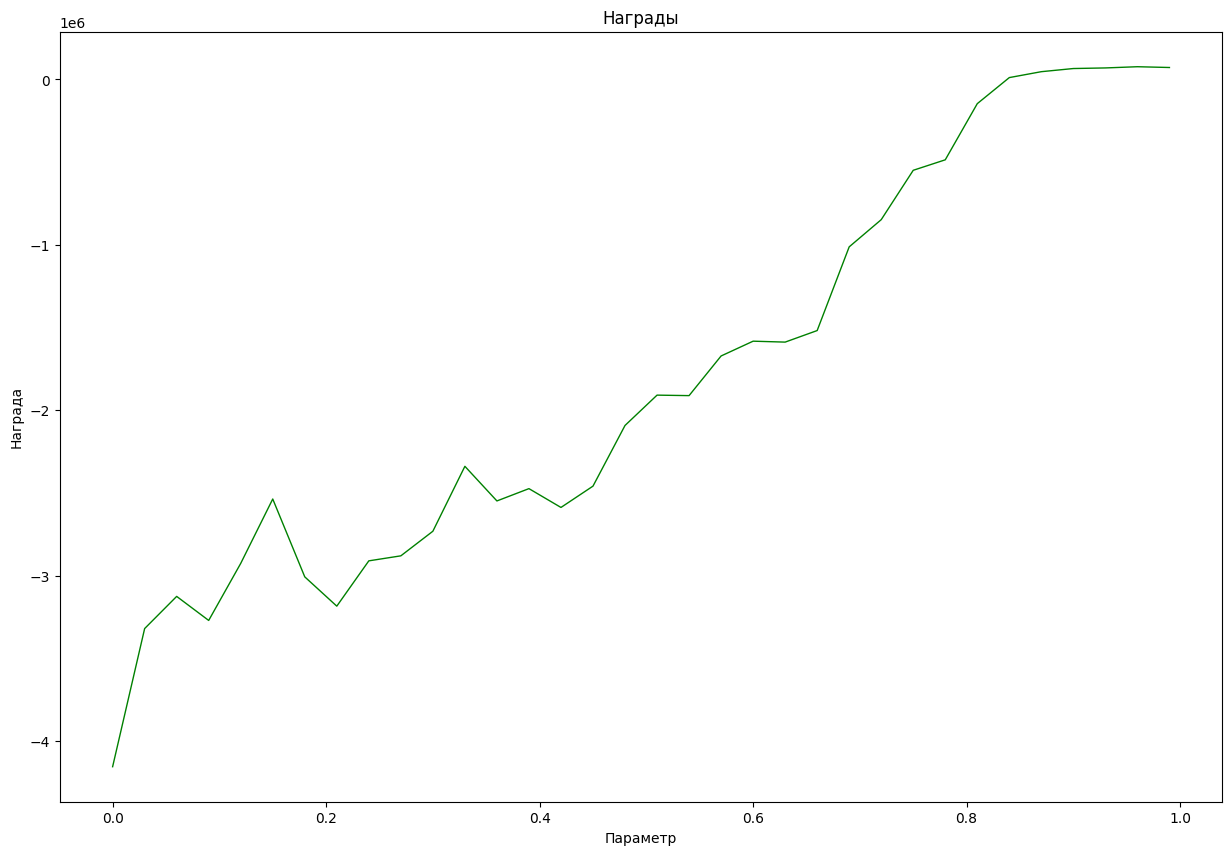

[14275, -36237, -122284, -256192, -449237, -692862, -1081280, -1599294, -2382478]
[-4159696, -200069, -48011, 1505, 33457, 46311, 57997, 57586, 72321, 72758, 72012, 82524, 79710, 81326, 67298, 74776, 60980, 70425, 57654, 57065, 51689, 49895, 25298, 19923, 1476, -8556, -32683, -72618, -71738, -123900, -180050, -233826, -409266, -584372]
[-4154816, -3319641, -3125166, -3270473, -2925664, -2536426, -3007059, -3184108, -2910249, -2879961, -2731265, -2338778, -2548098, -2473699, -2587428, -2458551, -2091846, -1908444, -1911406, -1671719, -1582309, -1587895, -1518071, -1012063, -847730, -549214, -485858, -146330, 11235, 46892, 65958, 69566, 76891, 72171]
Best params: eps=0.1, lr=0.32999999999999996, gamma=0.96


In [27]:
bruteforce_sarsa()

### SARSA

100%|██████████| 20000/20000 [00:02<00:00, 8231.48it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [  1.84915271   3.64042813   2.19531679   5.05163473   9.46349206
   -5.19423149]
 [  8.75723434   9.99537339   6.61258633   4.62700036  13.93768277
    2.45028668]
 ...
 [ -5.05408243  -4.96122278  -5.26398534   9.67278034  -8.14546143
  -10.53777378]
 [ -4.94684685  -5.66694023  -5.23644944   8.5120994   -5.511
   -8.49623421]
 [ -0.5511      -0.658911    -0.5511      18.75670769  -5.511
   -5.618811  ]]


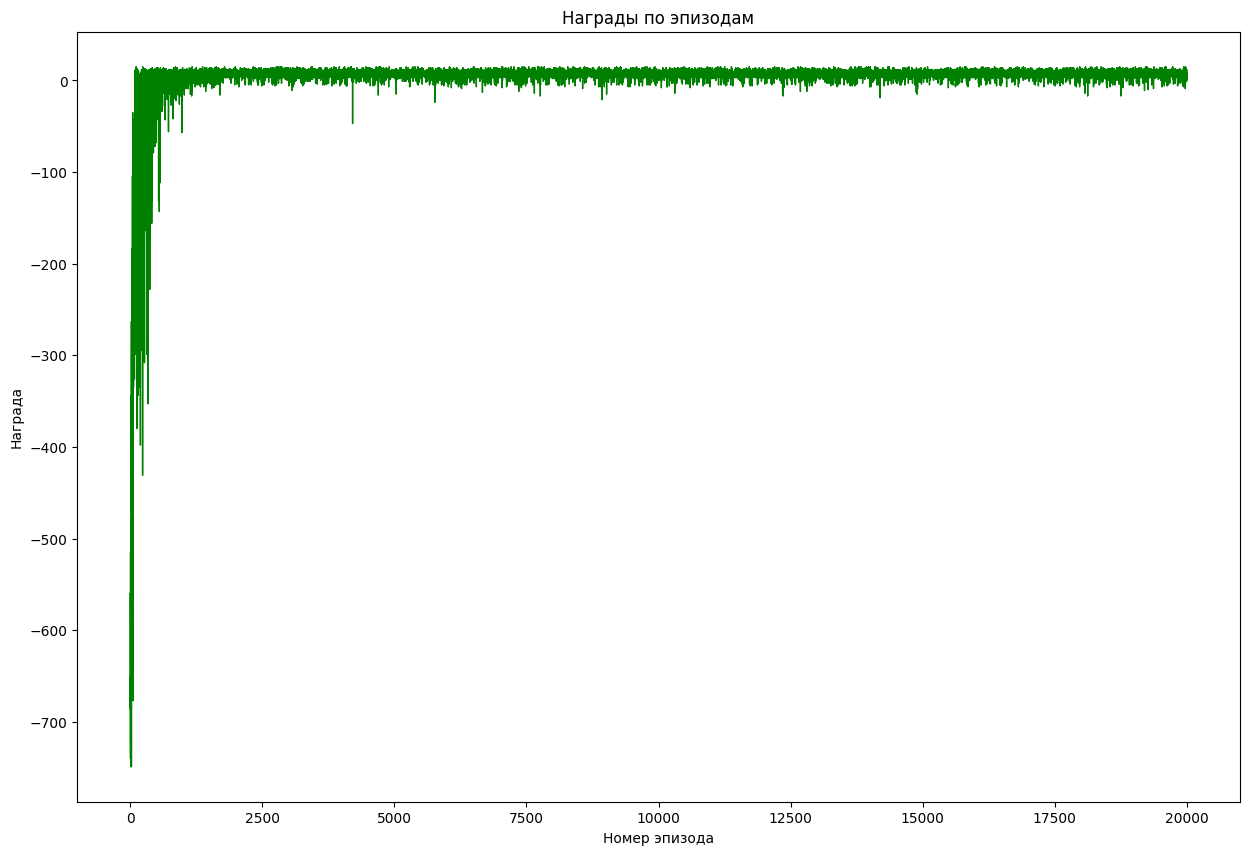

In [31]:
run_sarsa()

### Q-обучение

100%|██████████| 20000/20000 [00:03<00:00, 5543.77it/s]


Вывод Q-матрицы для алгоритма  Q-обучение
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 5.33652055  6.16563259  4.64654132  6.57058437  8.36234335 -2.75779058]
 [10.11244123 11.31628163  9.68466907 11.20295994 13.27445578  2.71924271]
 ...
 [12.68498359 14.5657712  12.5815048  11.33211512  3.52888345  3.85605936]
 [-0.57271641  8.7591213  -2.40752853  1.32367843 -8.99820949 -5.16226797]
 [ 4.43677854  6.86748485  7.42278364 18.59913146 -0.17598014  2.94708781]]


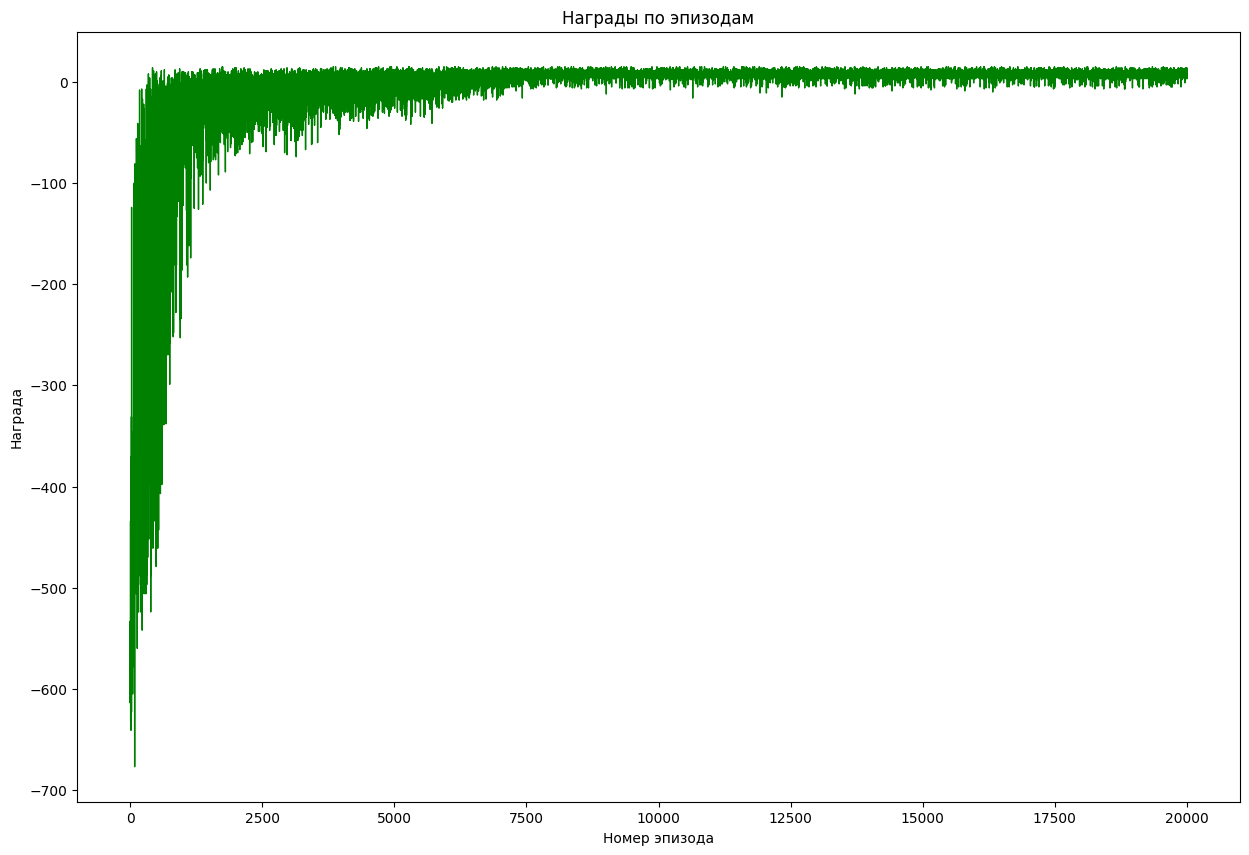

In [32]:
run_q_learning()

### Двойное Q-обучение

100%|██████████| 20000/20000 [00:04<00:00, 4844.28it/s]


Вывод Q-матриц для алгоритма Двойное Q-обучение
Q1
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 1.95815493  0.60426612 -0.43092799  2.05702783  8.36234335 -8.15062117]
 [ 6.45265856  7.1740071   0.38444805  7.36622461 13.27445578  0.32975268]
 ...
 [-2.56242031  5.99181447 -3.09038483 -2.85347722 -6.22903158 -3.77480542]
 [-3.95399803 -3.36693749 -3.20043979  3.95296728 -2.46696776 -7.36291357]
 [-0.1         1.8032735   1.54684159 18.2444813  -0.75876259  0.24577466]]
Q2
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 2.0512923   1.6197593  -1.68802908  2.09561175  8.36234335 -4.93190575]
 [ 5.55220446  4.93884512  4.86991646  7.9143074  13.27445578 -0.62367367]
 ...
 [-3.84712874  3.59576781 -2.83016316 -3.14109144 -3.46307264 -4.49754945]
 [-2.5272937  -2.44443565 -2.87108875  6.30500456 -6.387721   -6.27106992]
 [-0.1098      2.12320824  5.35221349 17.90991544 -0.19704504 -1.0098    ]]


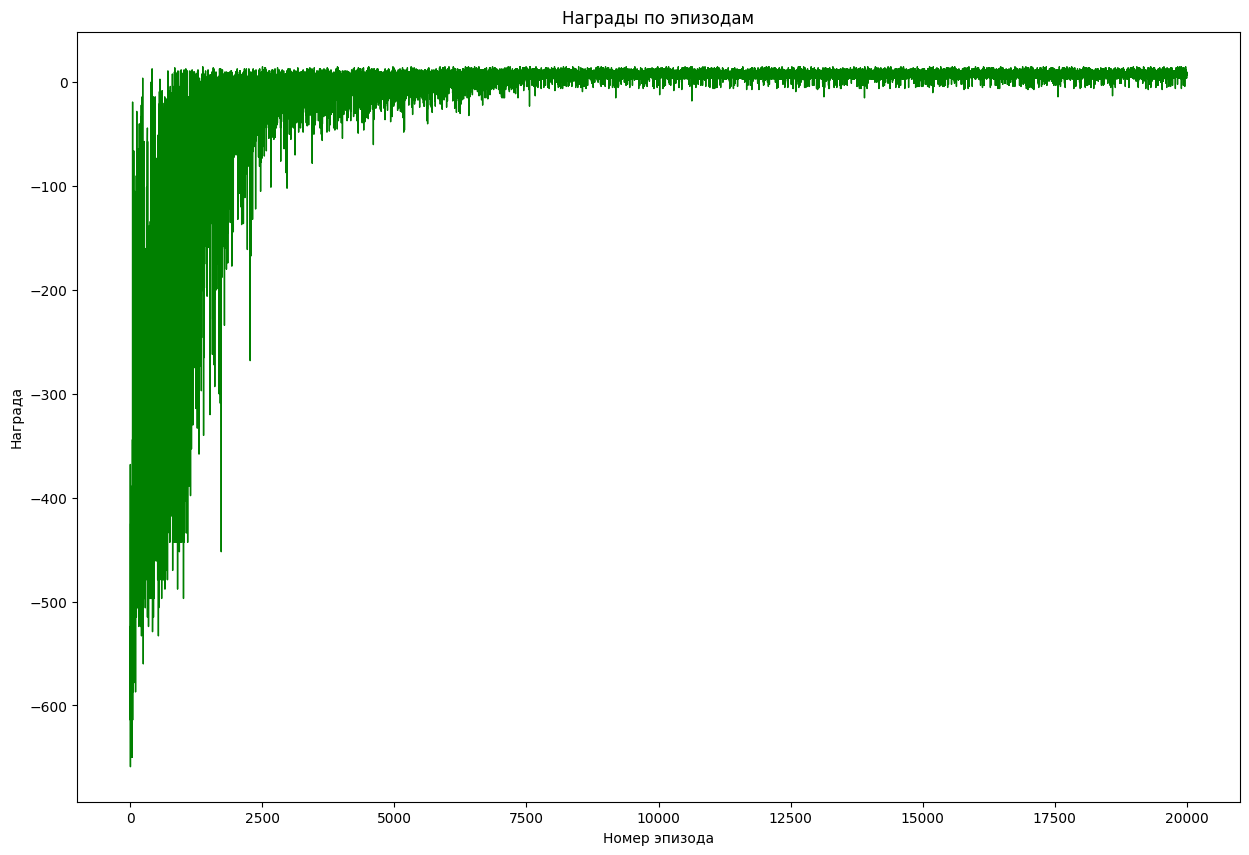

: 

In [33]:
run_double_q_learning()